# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            z = torch.randn(8*n_classes, z_dim).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
torch.cuda.is_available()

False

In [5]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

There are various examples of VAE in PyTorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

![A variational autoencoder.](vae.png)

In [6]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy. The code below is still from the PyTorch tutorial (with minor modifications to avoid warnings!).

In [7]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Epoch[1/15], Step [10/469], Reconst Loss: 280.4680, KL Div: 23.0409
Epoch[1/15], Step [20/469], Reconst Loss: 229.2075, KL Div: 8.4919
Epoch[1/15], Step [30/469], Reconst Loss: 212.2683, KL Div: 9.6824
Epoch[1/15], Step [40/469], Reconst Loss: 209.9946, KL Div: 5.1028
Epoch[1/15], Step [50/469], Reconst Loss: 199.5975, KL Div: 5.4557
Epoch[1/15], Step [60/469], Reconst Loss: 197.4291, KL Div: 6.5285
Epoch[1/15], Step [70/469], Reconst Loss: 194.6958, KL Div: 6.8586
Epoch[1/15], Step [80/469], Reconst Loss: 191.9424, KL Div: 7.1051
Epoch[1/15], Step [90/469], Reconst Loss: 182.2775, KL Div: 9.5398
Epoch[1/15], Step [100/469], Reconst Loss: 171.3773, KL Div: 12.1935
Epoch[1/15], Step [110/469], Reconst Loss: 171.9604, KL Div: 11.3722
Epoch[1/15], Step [120/469], Reconst Loss: 157.3353, KL Div: 13.4550
Epoch[1/15], Step [130/469], Reconst Loss: 154.8637, KL Div: 14.1177
Epoch[1/15], Step [140/469], Reconst Loss: 150.1750, KL Div: 14.5792
Epoch[1/15], Step [150/469], Reconst Loss: 143.6618

Epoch[3/15], Step [300/469], Reconst Loss: 85.6998, KL Div: 23.9126
Epoch[3/15], Step [310/469], Reconst Loss: 86.7105, KL Div: 24.4870
Epoch[3/15], Step [320/469], Reconst Loss: 89.9235, KL Div: 24.2042
Epoch[3/15], Step [330/469], Reconst Loss: 86.2686, KL Div: 24.0392
Epoch[3/15], Step [340/469], Reconst Loss: 86.4100, KL Div: 24.0556
Epoch[3/15], Step [350/469], Reconst Loss: 86.1600, KL Div: 24.2465
Epoch[3/15], Step [360/469], Reconst Loss: 89.3744, KL Div: 24.0294
Epoch[3/15], Step [370/469], Reconst Loss: 90.9175, KL Div: 23.7563
Epoch[3/15], Step [380/469], Reconst Loss: 85.6307, KL Div: 24.5253
Epoch[3/15], Step [390/469], Reconst Loss: 88.6573, KL Div: 23.8087
Epoch[3/15], Step [400/469], Reconst Loss: 89.8337, KL Div: 24.4098
Epoch[3/15], Step [410/469], Reconst Loss: 89.9150, KL Div: 24.4801
Epoch[3/15], Step [420/469], Reconst Loss: 88.3734, KL Div: 23.9322
Epoch[3/15], Step [430/469], Reconst Loss: 87.3512, KL Div: 24.2382
Epoch[3/15], Step [440/469], Reconst Loss: 86.97

Epoch[6/15], Step [130/469], Reconst Loss: 79.9582, KL Div: 23.9586
Epoch[6/15], Step [140/469], Reconst Loss: 81.0757, KL Div: 24.5394
Epoch[6/15], Step [150/469], Reconst Loss: 82.4476, KL Div: 24.3997
Epoch[6/15], Step [160/469], Reconst Loss: 84.2230, KL Div: 25.0509
Epoch[6/15], Step [170/469], Reconst Loss: 81.4644, KL Div: 24.2399
Epoch[6/15], Step [180/469], Reconst Loss: 84.4460, KL Div: 25.9957
Epoch[6/15], Step [190/469], Reconst Loss: 84.5179, KL Div: 24.5988
Epoch[6/15], Step [200/469], Reconst Loss: 79.0796, KL Div: 24.2524
Epoch[6/15], Step [210/469], Reconst Loss: 84.0298, KL Div: 24.9430
Epoch[6/15], Step [220/469], Reconst Loss: 85.3114, KL Div: 26.3983
Epoch[6/15], Step [230/469], Reconst Loss: 81.0148, KL Div: 24.3598
Epoch[6/15], Step [240/469], Reconst Loss: 83.2856, KL Div: 24.3601
Epoch[6/15], Step [250/469], Reconst Loss: 86.5627, KL Div: 25.2440
Epoch[6/15], Step [260/469], Reconst Loss: 82.0435, KL Div: 25.2172
Epoch[6/15], Step [270/469], Reconst Loss: 83.09

Epoch[8/15], Step [420/469], Reconst Loss: 80.3611, KL Div: 24.8282
Epoch[8/15], Step [430/469], Reconst Loss: 83.5202, KL Div: 25.6488
Epoch[8/15], Step [440/469], Reconst Loss: 81.8898, KL Div: 26.1685
Epoch[8/15], Step [450/469], Reconst Loss: 77.9755, KL Div: 24.5814
Epoch[8/15], Step [460/469], Reconst Loss: 80.5318, KL Div: 25.7394
Epoch[9/15], Step [10/469], Reconst Loss: 81.2156, KL Div: 25.2607
Epoch[9/15], Step [20/469], Reconst Loss: 79.5849, KL Div: 25.0204
Epoch[9/15], Step [30/469], Reconst Loss: 77.6291, KL Div: 24.5057
Epoch[9/15], Step [40/469], Reconst Loss: 83.3829, KL Div: 24.6870
Epoch[9/15], Step [50/469], Reconst Loss: 78.3391, KL Div: 25.3608
Epoch[9/15], Step [60/469], Reconst Loss: 83.8225, KL Div: 24.8746
Epoch[9/15], Step [70/469], Reconst Loss: 78.9929, KL Div: 24.4858
Epoch[9/15], Step [80/469], Reconst Loss: 81.9709, KL Div: 26.1962
Epoch[9/15], Step [90/469], Reconst Loss: 82.9354, KL Div: 24.9618
Epoch[9/15], Step [100/469], Reconst Loss: 83.5281, KL Di

Epoch[11/15], Step [240/469], Reconst Loss: 83.6096, KL Div: 25.9212
Epoch[11/15], Step [250/469], Reconst Loss: 80.9547, KL Div: 25.9004
Epoch[11/15], Step [260/469], Reconst Loss: 79.3444, KL Div: 24.5888
Epoch[11/15], Step [270/469], Reconst Loss: 76.4094, KL Div: 24.9981
Epoch[11/15], Step [280/469], Reconst Loss: 80.1938, KL Div: 25.7641
Epoch[11/15], Step [290/469], Reconst Loss: 78.8025, KL Div: 25.5941
Epoch[11/15], Step [300/469], Reconst Loss: 78.1629, KL Div: 24.4937
Epoch[11/15], Step [310/469], Reconst Loss: 82.1586, KL Div: 24.9944
Epoch[11/15], Step [320/469], Reconst Loss: 80.6448, KL Div: 25.0076
Epoch[11/15], Step [330/469], Reconst Loss: 82.5830, KL Div: 25.1068
Epoch[11/15], Step [340/469], Reconst Loss: 80.9213, KL Div: 25.4669
Epoch[11/15], Step [350/469], Reconst Loss: 79.0538, KL Div: 26.0701
Epoch[11/15], Step [360/469], Reconst Loss: 74.2321, KL Div: 23.9707
Epoch[11/15], Step [370/469], Reconst Loss: 79.7721, KL Div: 24.7036
Epoch[11/15], Step [380/469], Reco

Epoch[14/15], Step [70/469], Reconst Loss: 77.7137, KL Div: 25.2859
Epoch[14/15], Step [80/469], Reconst Loss: 79.0728, KL Div: 24.3853
Epoch[14/15], Step [90/469], Reconst Loss: 78.7745, KL Div: 25.6647
Epoch[14/15], Step [100/469], Reconst Loss: 78.7530, KL Div: 24.9398
Epoch[14/15], Step [110/469], Reconst Loss: 80.1433, KL Div: 25.1667
Epoch[14/15], Step [120/469], Reconst Loss: 81.2358, KL Div: 25.8681
Epoch[14/15], Step [130/469], Reconst Loss: 80.7609, KL Div: 25.8807
Epoch[14/15], Step [140/469], Reconst Loss: 81.2701, KL Div: 25.1568
Epoch[14/15], Step [150/469], Reconst Loss: 83.0216, KL Div: 25.9949
Epoch[14/15], Step [160/469], Reconst Loss: 78.2897, KL Div: 24.6709
Epoch[14/15], Step [170/469], Reconst Loss: 76.9218, KL Div: 25.1195
Epoch[14/15], Step [180/469], Reconst Loss: 84.4475, KL Div: 25.8596
Epoch[14/15], Step [190/469], Reconst Loss: 85.7257, KL Div: 24.9544
Epoch[14/15], Step [200/469], Reconst Loss: 77.4389, KL Div: 26.1160
Epoch[14/15], Step [210/469], Reconst

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

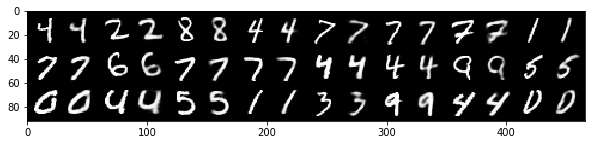

In [8]:
plt.figure(figsize=(10,5))
plot_reconstruction(model)

Let's see now how our network generates new samples.

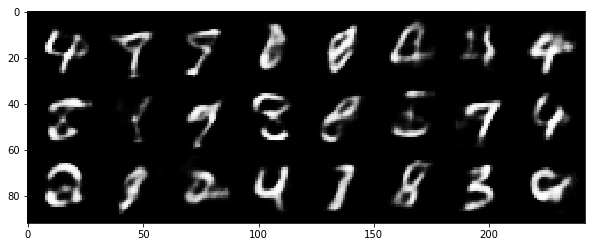

In [9]:
plt.figure(figsize=(10,5))
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this notebook, we explore ways to generates zeroes, ones, twos and so on. As a by-product, we show how our VAE will allow us to do clustering.

The main idea is to build what we call a Gumbel VAE as described below.

# Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|,c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NeurIPS paper: [(Dupont, 2018)](https://arxiv.org/abs/1804.00104). Make minimal modifications to previous architecture.

The idea is to incorporate a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planned, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation, we need to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in [(Jang et al., 2016)](https://arxiv.org/abs/1611.01144). This is implemented in PyTorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax).

In [10]:
n_classes = 10

class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(h_dim, n_classes)
        self.fc5 = nn.Linear(z_dim + n_classes , h_dim)
        self.fc6 = nn.Linear(h_dim, image_size)
        
        
    def encode(self, x):
        # use F.log_softmax
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h), F.log_softmax(self.fc4(h), dim=1)
        
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        # use torch.cat 
        zy = torch.cat((z, y_onehot), dim =1)
        h = F.relu(self.fc5(zy))
        return torch.sigmoid(self.fc6(h))
        
    
    def forward(self, x):
        # use F.gumbel_softmax
        mu, log_var, alpha = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_onehot = F.gumbel_softmax(alpha, dim=1)
        x_reconst = self.decode(z, y_onehot)
        return x_reconst, mu, log_var, y_onehot
        

model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in [(Dupont, 2018)](https://arxiv.org/abs/1804.00104)

**EXPLAIN:** 
From the paper:
$$D_{\mathrm{KL}}\left( q_{\phi}(z|c,
x)||p(z,c)\right) = D_{\mathrm{KL}}\left( q_{\phi}(z|x)||p(z)\right) + D_{\mathrm{KL}}\left( q_{\phi}(c|x)||p(c)\right)$$

$$D_{\mathrm{KL}}\left( q_{\phi}(z|x)||p(z)\right) = -\frac{1}{2} \sum _j(1 + \log(\sigma_j) - \mu_j^2 - \sigma_j^2 ) $$

$c \sim g(\alpha)$ where $g$ is Gumbel softmax distribution. 
$p(c)$ follows a Uniform Gumbel Softmax distribution. Hence in our case $p(c = 0) = \frac{1}{{n_{classes}}}$. We also have that $q_{\phi}(c|x)$ is a categorial random variable. Hence:

\begin{align} D_{\mathrm{KL}}\left( q_{\phi}(c|x)||p(c)\right) &= \sum_{i=1}^{n_{classes}} q_{i} \log \frac{q_i}{p_i} \\ &= \sum_{i=1}^{n_{classes}} q_i \log \frac{q_i}{1/n_{classes}} \\ &= \sum_{i=1}^{n_{classes}} q_i \log q_i + \sum_{i=1}^{n_{classes}} q_i\log n_{classes} \\ &= -H(q_{\phi}(c|x)) + \log(n_{classes})
\end{align}


we know that $q_i$ is returned by the model `g_alpha` and $p_i = 1/{n_{classes}}$ so we can compute the above straightforward. 




In [11]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, g_alpha = model(x)
            
            #NMI
            all_labels += labels.tolist()
            all_labels_est += torch.argmax(g_alpha, dim=1).tolist()
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            KL_div_z = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            pi = torch.tensor([1/n_classes], device=device)
            H_cat = - torch.sum(g_alpha * g_alpha.log(), dim=1) #entropy
            KL_div_c = torch.sum(-H_cat - torch.log(pi))#expectency
            H_cat = torch.sum(H_cat) #helps for the print
            
            KL_div = KL_div_z + KL_div_c

            # Backprop and optimize
            loss = reconst_loss + KL_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, kl_div_c: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   KL_div.item()/batch_size, KL_div_c.item()/batch_size, H_cat.item()/batch_size))
    
        nmi = normalized_mutual_info_score(all_labels, all_labels_est)
        nmi_scores.append(nmi)
    return nmi_scores

In [12]:
nmi = train_G(model_G,num_epochs=10,verbose=True)

Epoch[1/10], Step [10/469], Reconst Loss: 295.1200, KL Div: 26.0345, kl_div_c: 0.8705, Entropy: 1.4321
Epoch[1/10], Step [20/469], Reconst Loss: 230.7618, KL Div: 11.4876, kl_div_c: 0.8267, Entropy: 1.4759
Epoch[1/10], Step [30/469], Reconst Loss: 210.6908, KL Div: 11.4168, kl_div_c: 0.7331, Entropy: 1.5695
Epoch[1/10], Step [40/469], Reconst Loss: 213.6092, KL Div: 6.1947, kl_div_c: 0.8127, Entropy: 1.4899
Epoch[1/10], Step [50/469], Reconst Loss: 213.2608, KL Div: 6.0857, kl_div_c: 0.7319, Entropy: 1.5707
Epoch[1/10], Step [60/469], Reconst Loss: 194.5735, KL Div: 8.3373, kl_div_c: 0.8530, Entropy: 1.4496
Epoch[1/10], Step [70/469], Reconst Loss: 191.0280, KL Div: 8.1341, kl_div_c: 0.7007, Entropy: 1.6019
Epoch[1/10], Step [80/469], Reconst Loss: 186.1885, KL Div: 9.4600, kl_div_c: 0.8110, Entropy: 1.4916
Epoch[1/10], Step [90/469], Reconst Loss: 182.4014, KL Div: 10.4061, kl_div_c: 0.7752, Entropy: 1.5273
Epoch[1/10], Step [100/469], Reconst Loss: 167.1023, KL Div: 10.8398, kl_div_c

Epoch[2/10], Step [360/469], Reconst Loss: 96.3562, KL Div: 24.2324, kl_div_c: 0.9053, Entropy: 1.3973
Epoch[2/10], Step [370/469], Reconst Loss: 96.4445, KL Div: 23.5538, kl_div_c: 0.7874, Entropy: 1.5152
Epoch[2/10], Step [380/469], Reconst Loss: 100.3413, KL Div: 23.1441, kl_div_c: 0.7940, Entropy: 1.5085
Epoch[2/10], Step [390/469], Reconst Loss: 97.1417, KL Div: 23.0517, kl_div_c: 0.8232, Entropy: 1.4794
Epoch[2/10], Step [400/469], Reconst Loss: 97.8630, KL Div: 24.5772, kl_div_c: 0.7859, Entropy: 1.5166
Epoch[2/10], Step [410/469], Reconst Loss: 96.3037, KL Div: 23.4475, kl_div_c: 0.8221, Entropy: 1.4805
Epoch[2/10], Step [420/469], Reconst Loss: 94.6042, KL Div: 23.9405, kl_div_c: 0.8370, Entropy: 1.4656
Epoch[2/10], Step [430/469], Reconst Loss: 93.1109, KL Div: 23.6861, kl_div_c: 0.8228, Entropy: 1.4798
Epoch[2/10], Step [440/469], Reconst Loss: 89.5210, KL Div: 23.2082, kl_div_c: 0.8589, Entropy: 1.4437
Epoch[2/10], Step [450/469], Reconst Loss: 95.3203, KL Div: 23.9715, kl_

Epoch[4/10], Step [240/469], Reconst Loss: 90.0141, KL Div: 25.9489, kl_div_c: 0.8821, Entropy: 1.4204
Epoch[4/10], Step [250/469], Reconst Loss: 86.7645, KL Div: 24.2895, kl_div_c: 0.8531, Entropy: 1.4495
Epoch[4/10], Step [260/469], Reconst Loss: 85.2858, KL Div: 24.3796, kl_div_c: 0.8647, Entropy: 1.4378
Epoch[4/10], Step [270/469], Reconst Loss: 86.7122, KL Div: 25.0789, kl_div_c: 0.8843, Entropy: 1.4183
Epoch[4/10], Step [280/469], Reconst Loss: 86.2826, KL Div: 25.2506, kl_div_c: 0.8689, Entropy: 1.4336
Epoch[4/10], Step [290/469], Reconst Loss: 85.4547, KL Div: 24.3982, kl_div_c: 0.7935, Entropy: 1.5091
Epoch[4/10], Step [300/469], Reconst Loss: 86.6593, KL Div: 25.2175, kl_div_c: 0.8873, Entropy: 1.4153
Epoch[4/10], Step [310/469], Reconst Loss: 87.6785, KL Div: 24.8530, kl_div_c: 0.8451, Entropy: 1.4575
Epoch[4/10], Step [320/469], Reconst Loss: 90.9963, KL Div: 25.2194, kl_div_c: 0.8478, Entropy: 1.4547
Epoch[4/10], Step [330/469], Reconst Loss: 86.1209, KL Div: 25.6777, kl_d

Epoch[6/10], Step [120/469], Reconst Loss: 79.6047, KL Div: 26.0532, kl_div_c: 0.9728, Entropy: 1.3298
Epoch[6/10], Step [130/469], Reconst Loss: 83.4009, KL Div: 24.9404, kl_div_c: 0.9327, Entropy: 1.3698
Epoch[6/10], Step [140/469], Reconst Loss: 84.4448, KL Div: 25.3086, kl_div_c: 1.0339, Entropy: 1.2687
Epoch[6/10], Step [150/469], Reconst Loss: 85.1350, KL Div: 25.0883, kl_div_c: 0.9725, Entropy: 1.3301
Epoch[6/10], Step [160/469], Reconst Loss: 85.2895, KL Div: 26.3023, kl_div_c: 1.0634, Entropy: 1.2392
Epoch[6/10], Step [170/469], Reconst Loss: 85.0454, KL Div: 25.5512, kl_div_c: 0.9588, Entropy: 1.3438
Epoch[6/10], Step [180/469], Reconst Loss: 84.3430, KL Div: 24.4437, kl_div_c: 0.9417, Entropy: 1.3609
Epoch[6/10], Step [190/469], Reconst Loss: 84.8051, KL Div: 25.3519, kl_div_c: 1.0515, Entropy: 1.2511
Epoch[6/10], Step [200/469], Reconst Loss: 84.5283, KL Div: 25.8084, kl_div_c: 1.0059, Entropy: 1.2966
Epoch[6/10], Step [210/469], Reconst Loss: 82.0020, KL Div: 25.5126, kl_d

Epoch[7/10], Step [460/469], Reconst Loss: 82.2174, KL Div: 26.2105, kl_div_c: 1.0775, Entropy: 1.2251
Epoch[8/10], Step [10/469], Reconst Loss: 83.3760, KL Div: 26.2050, kl_div_c: 1.0606, Entropy: 1.2420
Epoch[8/10], Step [20/469], Reconst Loss: 84.2019, KL Div: 24.6718, kl_div_c: 1.1664, Entropy: 1.1362
Epoch[8/10], Step [30/469], Reconst Loss: 78.6096, KL Div: 25.2315, kl_div_c: 1.1450, Entropy: 1.1576
Epoch[8/10], Step [40/469], Reconst Loss: 83.4072, KL Div: 26.1050, kl_div_c: 1.0923, Entropy: 1.2102
Epoch[8/10], Step [50/469], Reconst Loss: 79.4022, KL Div: 25.7870, kl_div_c: 1.0617, Entropy: 1.2409
Epoch[8/10], Step [60/469], Reconst Loss: 79.8605, KL Div: 25.6492, kl_div_c: 1.0975, Entropy: 1.2051
Epoch[8/10], Step [70/469], Reconst Loss: 82.6697, KL Div: 26.5918, kl_div_c: 1.2376, Entropy: 1.0650
Epoch[8/10], Step [80/469], Reconst Loss: 81.7360, KL Div: 25.2930, kl_div_c: 1.1330, Entropy: 1.1696
Epoch[8/10], Step [90/469], Reconst Loss: 79.9451, KL Div: 25.1960, kl_div_c: 1.0

Epoch[9/10], Step [340/469], Reconst Loss: 78.1807, KL Div: 25.5927, kl_div_c: 1.1589, Entropy: 1.1437
Epoch[9/10], Step [350/469], Reconst Loss: 76.0228, KL Div: 24.6052, kl_div_c: 1.2495, Entropy: 1.0531
Epoch[9/10], Step [360/469], Reconst Loss: 77.3524, KL Div: 25.3444, kl_div_c: 1.2250, Entropy: 1.0776
Epoch[9/10], Step [370/469], Reconst Loss: 79.9855, KL Div: 25.3141, kl_div_c: 1.2131, Entropy: 1.0895
Epoch[9/10], Step [380/469], Reconst Loss: 80.7774, KL Div: 25.9159, kl_div_c: 1.1588, Entropy: 1.1438
Epoch[9/10], Step [390/469], Reconst Loss: 80.6546, KL Div: 26.7785, kl_div_c: 1.2016, Entropy: 1.1010
Epoch[9/10], Step [400/469], Reconst Loss: 80.3757, KL Div: 24.8518, kl_div_c: 1.2196, Entropy: 1.0830
Epoch[9/10], Step [410/469], Reconst Loss: 79.9937, KL Div: 25.3665, kl_div_c: 1.2798, Entropy: 1.0228
Epoch[9/10], Step [420/469], Reconst Loss: 84.3919, KL Div: 25.7724, kl_div_c: 1.1568, Entropy: 1.1458
Epoch[9/10], Step [430/469], Reconst Loss: 81.3612, KL Div: 25.2662, kl_d

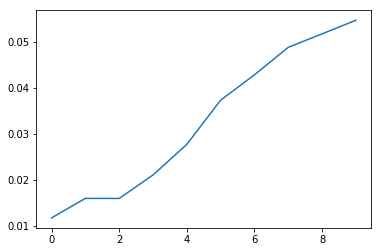

In [13]:
plt.plot(nmi)
plt.show()

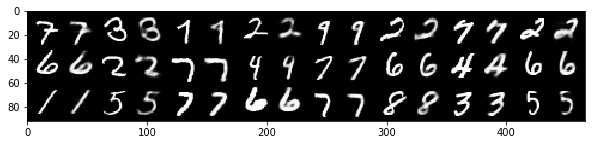

In [14]:
plt.figure(figsize=(10,5))
plot_reconstruction(model_G)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the `plot_conditional_generation()` function.

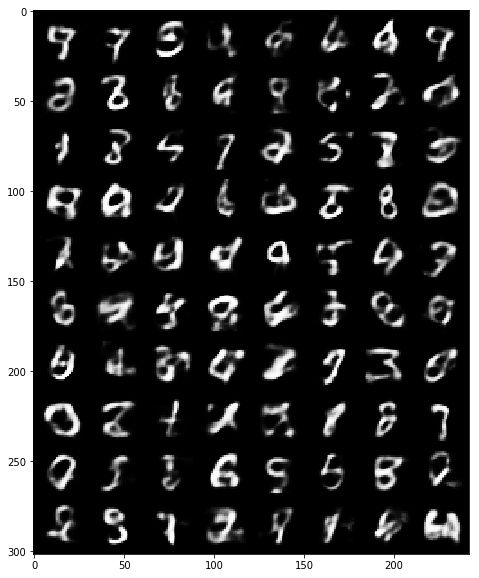

In [15]:
plt.figure(figsize=(10,10))
plot_conditional_generation(model_G, n=8)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable. We can track the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) (see [this method in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)) between the true labels and the labels predicted by our network (just by taking the category with maximal probability). 

Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

This problem is explained in [(Burgess et al., 2018)](https://arxiv.org/abs/1804.03599) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to [(Dupont, 2018)](https://arxiv.org/abs/1804.00104), Section 3 Equation (7).

Implement this change in the training loop and plot the new NMI curve. For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [16]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [17]:
def train_G_modified_loss(model, data_loader=data_loader,num_epochs=num_epochs, beta = 20, C_z_fin=100, C_c_fin=100, verbose=True):
    #progress of C
    Cz = np.linspace(0, C_z_fin, num_epochs*len(data_loader))
    Cc = np.linspace(0, C_c_fin, num_epochs*len(data_loader))
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, g_alpha = model(x)
            
            #NMI
            all_labels += labels.tolist()
            all_labels_est += torch.argmax(g_alpha, dim=1).tolist()
            
            #update C
            cz_i = Cz[epoch * len(data_loader) + i]
            cc_i = Cc[epoch * len(data_loader) + i]
            
            #compute KL+reconst_loss
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            KL_div_z = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            pi = torch.tensor([1/n_classes], device=device)
            H_cat = - torch.sum(g_alpha * g_alpha.log(), dim=1) #entropy
            KL_div_c = torch.sum(-H_cat - torch.log(pi))#expectency
            H_cat = torch.sum(H_cat) #print
            
            KL_div = torch.abs(KL_div_z - cz_i) + torch.abs(KL_div_c - cc_i)

            # Backprop and optimize
            loss = reconst_loss + beta * KL_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, kl_div_c: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   KL_div.item()/batch_size, KL_div_c.item()/batch_size, H_cat.item()/batch_size))
    
        nmi = normalized_mutual_info_score(all_labels, all_labels_est)
        nmi_scores.append(nmi)
    return nmi_scores

In [18]:
# Hyper-parameters
num_epochs = 10
learning_rate = 1e-3
beta = 20
C_z_fin=200
C_c_fin=200

model_G = VAE_Gumbel(z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

nmi2 = train_G_modified_loss(model_G, data_loader, num_epochs=num_epochs, beta=beta, C_z_fin=C_z_fin, C_c_fin=C_c_fin)

Epoch[1/10], Step [10/469], Reconst Loss: 361.9930, KL Div: 1.1431, kl_div_c: 0.7135, Entropy: 1.5891
Epoch[1/10], Step [20/469], Reconst Loss: 266.8614, KL Div: 1.1479, kl_div_c: 0.7970, Entropy: 1.5056
Epoch[1/10], Step [30/469], Reconst Loss: 233.8723, KL Div: 0.7880, kl_div_c: 0.6376, Entropy: 1.6649
Epoch[1/10], Step [40/469], Reconst Loss: 217.1987, KL Div: 0.7628, kl_div_c: 0.7165, Entropy: 1.5861
Epoch[1/10], Step [50/469], Reconst Loss: 209.0176, KL Div: 0.7683, kl_div_c: 0.7318, Entropy: 1.5708
Epoch[1/10], Step [60/469], Reconst Loss: 212.4091, KL Div: 0.7251, kl_div_c: 0.7157, Entropy: 1.5869
Epoch[1/10], Step [70/469], Reconst Loss: 203.4849, KL Div: 0.7604, kl_div_c: 0.7616, Entropy: 1.5410
Epoch[1/10], Step [80/469], Reconst Loss: 206.2180, KL Div: 0.7316, kl_div_c: 0.7421, Entropy: 1.5604
Epoch[1/10], Step [90/469], Reconst Loss: 211.9227, KL Div: 0.6748, kl_div_c: 0.6931, Entropy: 1.6095
Epoch[1/10], Step [100/469], Reconst Loss: 213.9233, KL Div: 0.6717, kl_div_c: 0.7

Epoch[2/10], Step [360/469], Reconst Loss: 200.7465, KL Div: 0.6334, kl_div_c: 0.8135, Entropy: 1.4891
Epoch[2/10], Step [370/469], Reconst Loss: 201.4937, KL Div: 0.5598, kl_div_c: 0.8105, Entropy: 1.4920
Epoch[2/10], Step [380/469], Reconst Loss: 187.0130, KL Div: 0.5620, kl_div_c: 0.8358, Entropy: 1.4668
Epoch[2/10], Step [390/469], Reconst Loss: 200.8073, KL Div: 0.7348, kl_div_c: 0.9662, Entropy: 1.3364
Epoch[2/10], Step [400/469], Reconst Loss: 191.2785, KL Div: 0.5218, kl_div_c: 0.7483, Entropy: 1.5543
Epoch[2/10], Step [410/469], Reconst Loss: 196.6665, KL Div: 0.6241, kl_div_c: 0.9132, Entropy: 1.3894
Epoch[2/10], Step [420/469], Reconst Loss: 203.2082, KL Div: 0.6488, kl_div_c: 0.8561, Entropy: 1.4465
Epoch[2/10], Step [430/469], Reconst Loss: 190.0320, KL Div: 0.5951, kl_div_c: 0.8916, Entropy: 1.4110
Epoch[2/10], Step [440/469], Reconst Loss: 191.7600, KL Div: 0.6349, kl_div_c: 0.9279, Entropy: 1.3747
Epoch[2/10], Step [450/469], Reconst Loss: 185.4326, KL Div: 0.5631, kl_d

Epoch[4/10], Step [240/469], Reconst Loss: 171.1727, KL Div: 0.5114, kl_div_c: 1.0477, Entropy: 1.2549
Epoch[4/10], Step [250/469], Reconst Loss: 175.9210, KL Div: 0.6018, kl_div_c: 1.1274, Entropy: 1.1751
Epoch[4/10], Step [260/469], Reconst Loss: 183.3535, KL Div: 0.6074, kl_div_c: 1.1447, Entropy: 1.1579
Epoch[4/10], Step [270/469], Reconst Loss: 181.6243, KL Div: 0.7469, kl_div_c: 1.1684, Entropy: 1.1341
Epoch[4/10], Step [280/469], Reconst Loss: 168.9156, KL Div: 0.5958, kl_div_c: 1.1517, Entropy: 1.1509
Epoch[4/10], Step [290/469], Reconst Loss: 177.0652, KL Div: 0.5348, kl_div_c: 1.0984, Entropy: 1.2042
Epoch[4/10], Step [300/469], Reconst Loss: 173.7195, KL Div: 0.5964, kl_div_c: 1.1151, Entropy: 1.1874
Epoch[4/10], Step [310/469], Reconst Loss: 168.8157, KL Div: 0.5485, kl_div_c: 1.1188, Entropy: 1.1838
Epoch[4/10], Step [320/469], Reconst Loss: 169.2568, KL Div: 0.5269, kl_div_c: 1.0843, Entropy: 1.2183
Epoch[4/10], Step [330/469], Reconst Loss: 167.7011, KL Div: 0.5960, kl_d

Epoch[6/10], Step [120/469], Reconst Loss: 163.7044, KL Div: 0.5132, kl_div_c: 1.2325, Entropy: 1.0701
Epoch[6/10], Step [130/469], Reconst Loss: 154.5301, KL Div: 0.5222, kl_div_c: 1.3087, Entropy: 0.9939
Epoch[6/10], Step [140/469], Reconst Loss: 167.0006, KL Div: 0.5155, kl_div_c: 1.2715, Entropy: 1.0311
Epoch[6/10], Step [150/469], Reconst Loss: 159.6521, KL Div: 0.4604, kl_div_c: 1.2635, Entropy: 1.0391
Epoch[6/10], Step [160/469], Reconst Loss: 161.4373, KL Div: 0.4846, kl_div_c: 1.2921, Entropy: 1.0105
Epoch[6/10], Step [170/469], Reconst Loss: 170.7014, KL Div: 0.4848, kl_div_c: 1.2913, Entropy: 1.0113
Epoch[6/10], Step [180/469], Reconst Loss: 164.7258, KL Div: 0.5706, kl_div_c: 1.3764, Entropy: 0.9262
Epoch[6/10], Step [190/469], Reconst Loss: 164.3643, KL Div: 0.6075, kl_div_c: 1.3560, Entropy: 0.9466
Epoch[6/10], Step [200/469], Reconst Loss: 160.7393, KL Div: 0.5569, kl_div_c: 1.2759, Entropy: 1.0267
Epoch[6/10], Step [210/469], Reconst Loss: 162.2950, KL Div: 0.5282, kl_d

Epoch[8/10], Step [10/469], Reconst Loss: 147.9157, KL Div: 0.3395, kl_div_c: 1.3760, Entropy: 0.9266
Epoch[8/10], Step [20/469], Reconst Loss: 158.2830, KL Div: 0.2923, kl_div_c: 1.3158, Entropy: 0.9868
Epoch[8/10], Step [30/469], Reconst Loss: 149.3812, KL Div: 0.4918, kl_div_c: 1.4406, Entropy: 0.8620
Epoch[8/10], Step [40/469], Reconst Loss: 153.6883, KL Div: 0.2854, kl_div_c: 1.3486, Entropy: 0.9540
Epoch[8/10], Step [50/469], Reconst Loss: 157.5706, KL Div: 0.2426, kl_div_c: 1.2984, Entropy: 1.0042
Epoch[8/10], Step [60/469], Reconst Loss: 155.7046, KL Div: 0.2452, kl_div_c: 1.3102, Entropy: 0.9924
Epoch[8/10], Step [70/469], Reconst Loss: 154.1312, KL Div: 0.2837, kl_div_c: 1.3717, Entropy: 0.9309
Epoch[8/10], Step [80/469], Reconst Loss: 151.2594, KL Div: 0.3405, kl_div_c: 1.4084, Entropy: 0.8942
Epoch[8/10], Step [90/469], Reconst Loss: 151.2448, KL Div: 0.2805, kl_div_c: 1.3966, Entropy: 0.9059
Epoch[8/10], Step [100/469], Reconst Loss: 152.3312, KL Div: 0.1934, kl_div_c: 1.3

Epoch[9/10], Step [360/469], Reconst Loss: 149.3820, KL Div: 0.0146, kl_div_c: 1.3828, Entropy: 0.9198
Epoch[9/10], Step [370/469], Reconst Loss: 146.5112, KL Div: 0.2613, kl_div_c: 1.4679, Entropy: 0.8347
Epoch[9/10], Step [380/469], Reconst Loss: 146.8069, KL Div: 0.2550, kl_div_c: 1.4972, Entropy: 0.8054
Epoch[9/10], Step [390/469], Reconst Loss: 145.2568, KL Div: 0.0259, kl_div_c: 1.3979, Entropy: 0.9047
Epoch[9/10], Step [400/469], Reconst Loss: 151.5133, KL Div: 0.0424, kl_div_c: 1.4081, Entropy: 0.8944
Epoch[9/10], Step [410/469], Reconst Loss: 148.0778, KL Div: 0.2079, kl_div_c: 1.4743, Entropy: 0.8282
Epoch[9/10], Step [420/469], Reconst Loss: 146.9401, KL Div: 0.1093, kl_div_c: 1.4535, Entropy: 0.8491
Epoch[9/10], Step [430/469], Reconst Loss: 154.3862, KL Div: 0.1292, kl_div_c: 1.4589, Entropy: 0.8437
Epoch[9/10], Step [440/469], Reconst Loss: 146.5577, KL Div: 0.0418, kl_div_c: 1.4002, Entropy: 0.9023
Epoch[9/10], Step [450/469], Reconst Loss: 139.4093, KL Div: 0.2030, kl_d

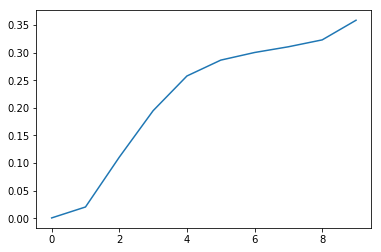

In [19]:
plt.plot(nmi2)
plt.show()

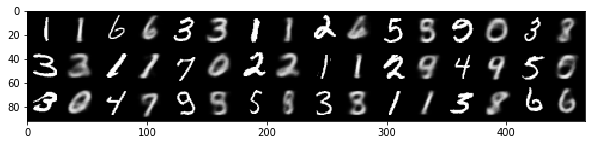

In [20]:
plt.figure(figsize=(10,5))
plot_reconstruction(model_G)

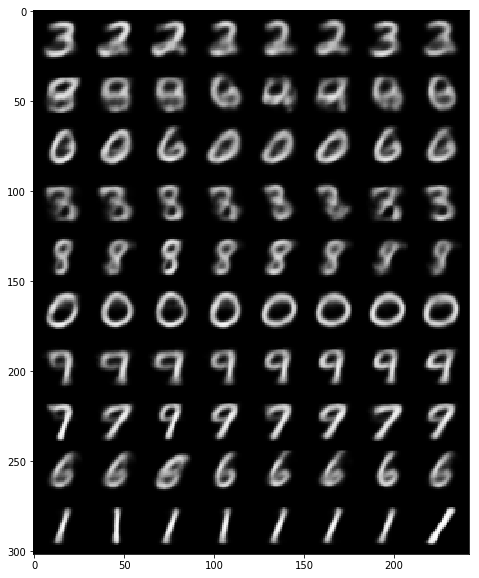

In [21]:
plt.figure(figsize=(10,10))
plot_conditional_generation(model_G, fix_number=None)

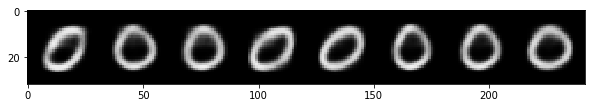

In [24]:
plt.figure(figsize=(10,5))
plot_conditional_generation(model_G, fix_number=5)